In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import cython
import time

(194, 259, 3)
(194, 259)


<Figure size 432x288 with 0 Axes>

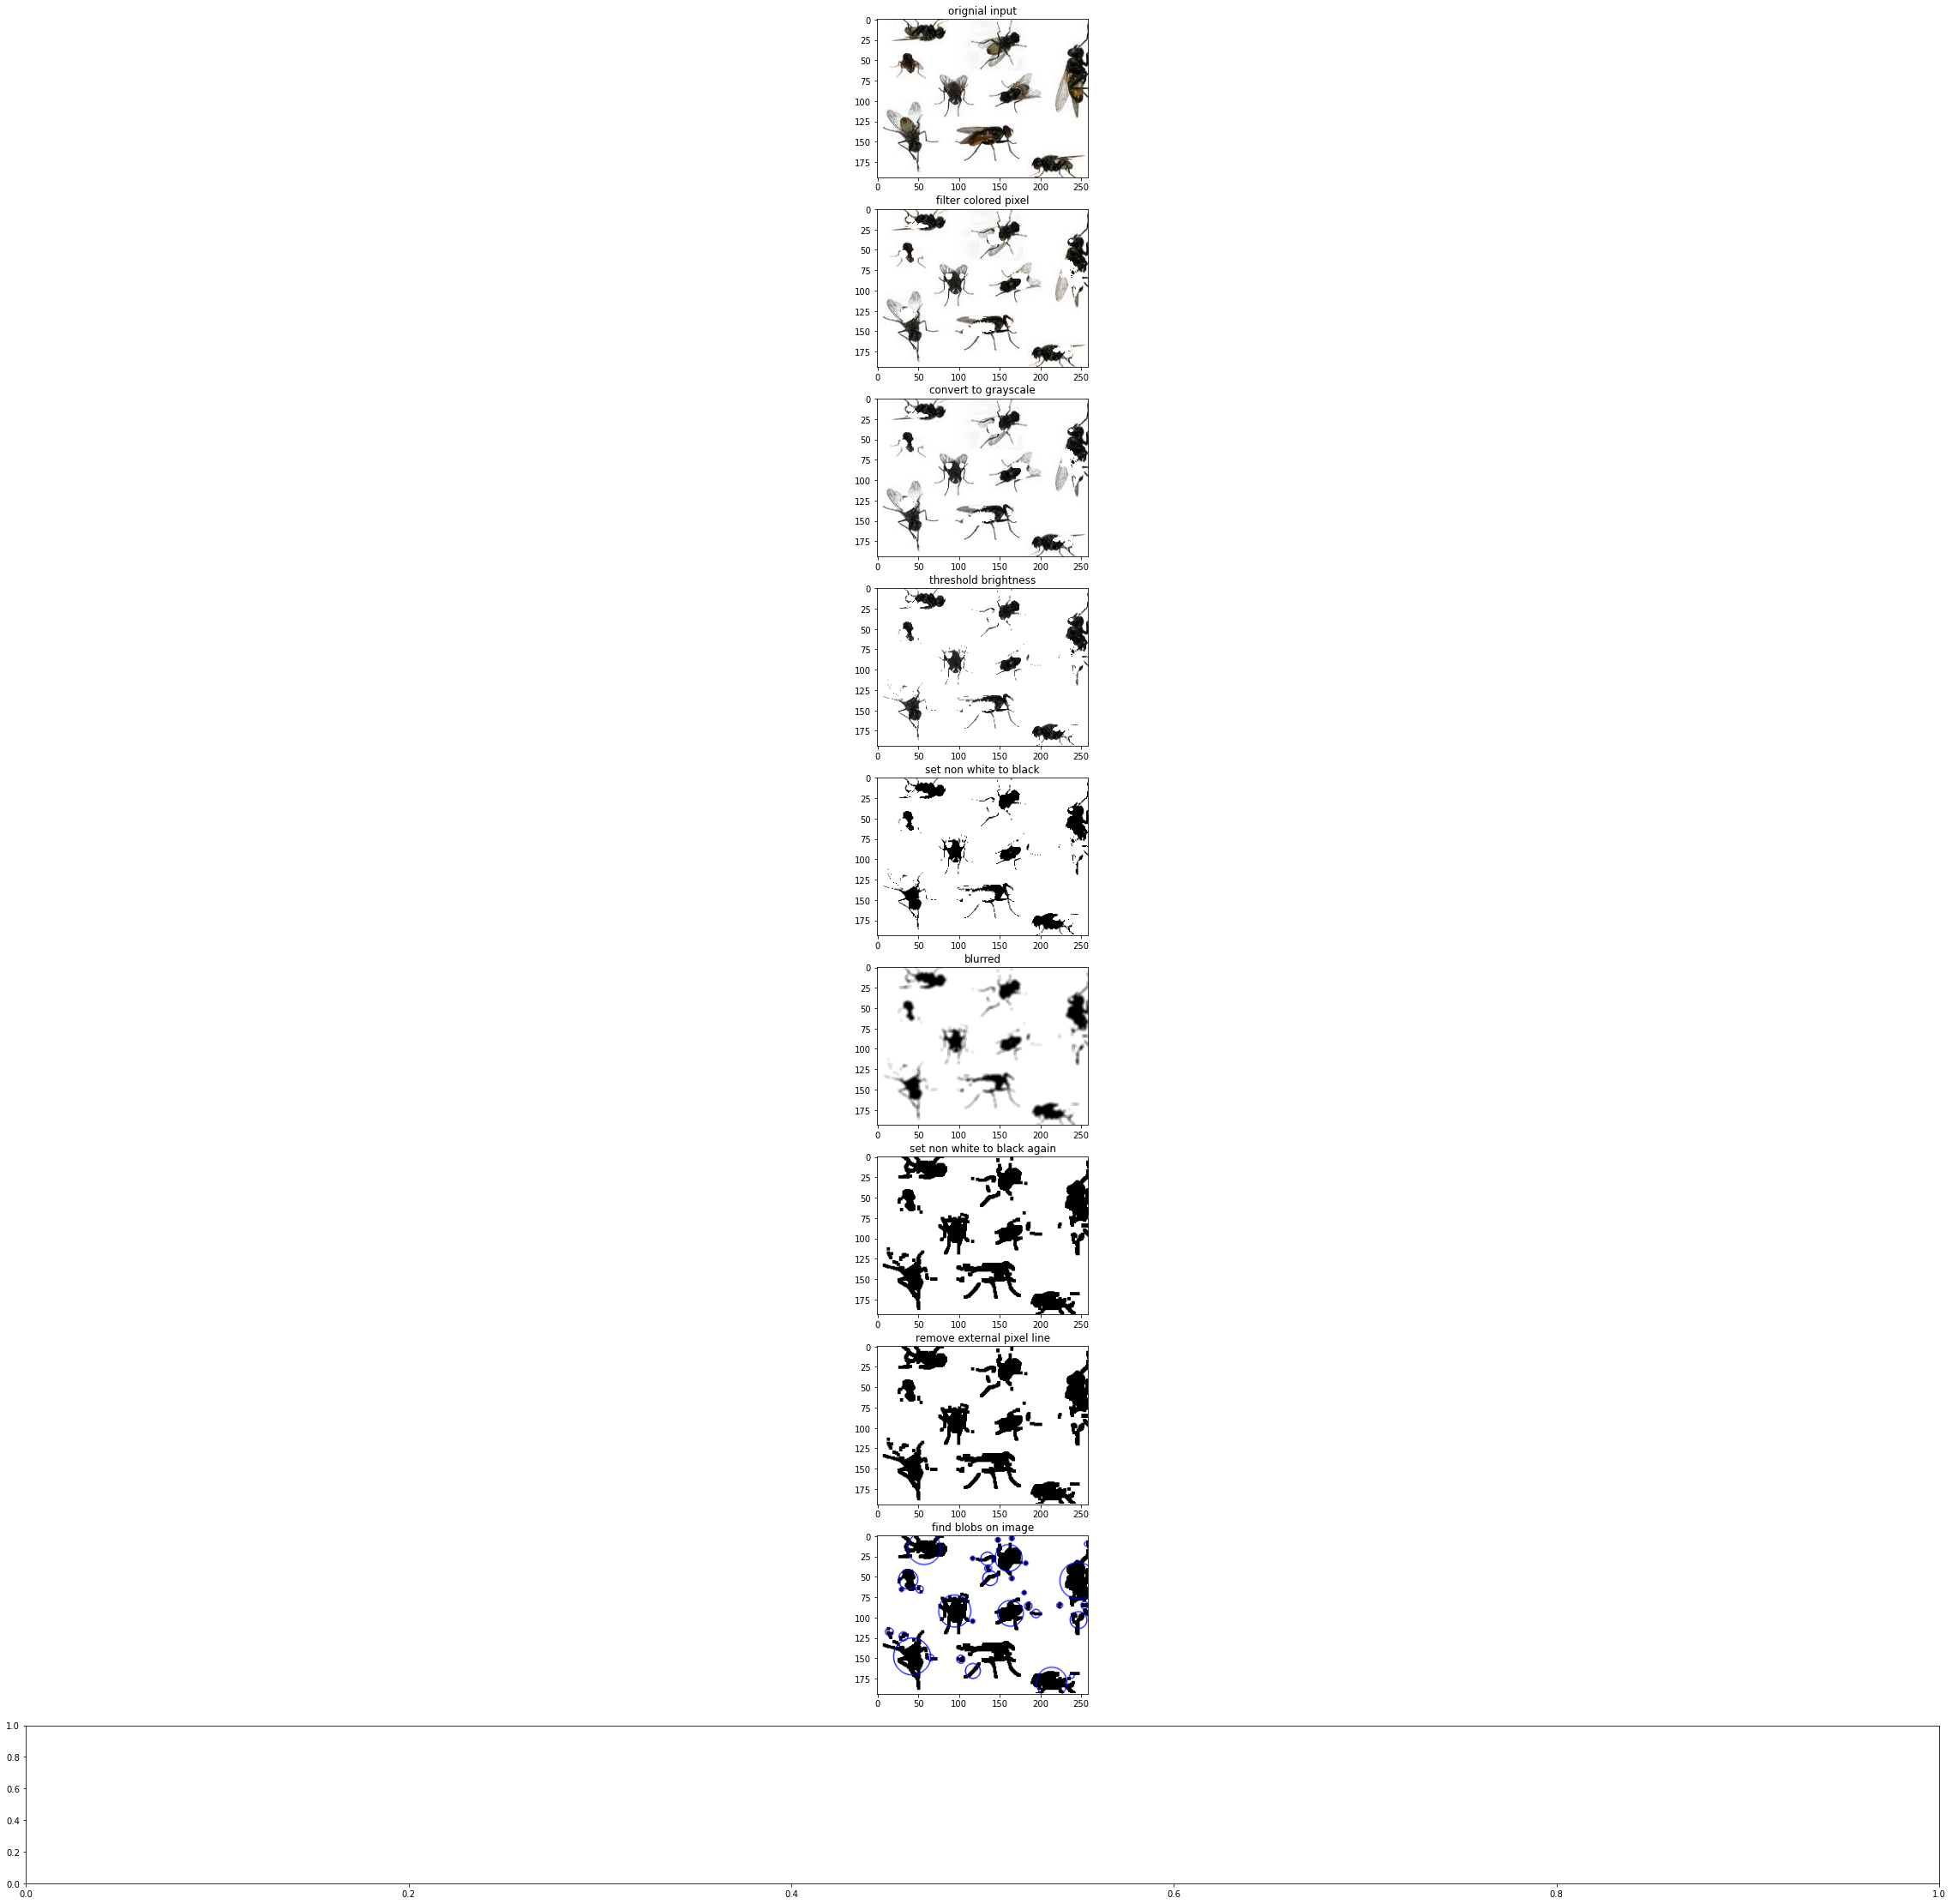

(48, 64, 3)
(48, 64)
t =  72  ms


error: OpenCV(4.5.2) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numerical tuple
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


In [26]:
img = cv.imread('flies.jpg')


#pipeline constants
replacement_vector = [255, 255, 255]
distance_threshold = 10
grayscale_threshold = 120
scale_percent = 25
blur_kernel_size = (4, 4)
BLOBS_SIZES_BOUNDS = (7, 10)

#for the blob detection
params = cv.SimpleBlobDetector_Params()
params.filterByConvexity = False
params.filterByCircularity = False
params.filterByInertia = False
params.filterByArea = False


"""
this method takes a vector of rgb components @rgb_vec and
replace it with @replace if the average absolute difference
with each component regarding the average of the components
exceeds the threshold. In other word, this function aim to
replace the vector by another if the pixel is not as grayscaled
as we want
"""
def compute_avg_diff_comp(rgb_vec, replace, thresh):
    assert(rgb_vec.shape[0] == 3)
    mean = np.mean(rgb_vec)
    sub = np.abs(rgb_vec - mean)
    sub_mean = np.max(sub)
    if (sub_mean < thresh):
        return rgb_vec
    else:
        return replace
        
"""
this methods takes an image and filter it with @compute_avg_diff_comp
the resulting image is an image where the pixels not satisfying the threshod
are full white.
"""
def filter_image_thresh(img):
    global replacement_vector
    global distance_threshold
    replace_vec = np.array(replacement_vector, dtype=np.uint8)
    result = []
    for i in range(0, len(img)):
        for j in range(0, len(img[0])):
            rgb_vec = img[i][j]
            result.append(compute_avg_diff_comp(rgb_vec, replace_vec, distance_threshold))
    result = np.asarray(result, dtype=np.uint8)
    result = result.reshape((img.shape[0], img.shape[1], img.shape[2]))
    return result


"""
convert an rgb numpy array to a grayscale numpy array
the type must be uint8 for each component
"""
def convert_rgb_to_grayscale(img):
    print(img.shape)
    i = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    print(i.shape)
    return i

def convert_bgr_to_rgb(img):
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

"""
given a grayscale image, set the pixel having 
brightness greater than threshold to white
"""
def apply_threshold_grayscale(img):
    global grayscale_threshold
    img[img > grayscale_threshold] = 255
    return img

"""
set all non white pixels to black
"""
def apply_threshold_set_black(img):
    img[img != 255] = 0
    return img


def resize_img(img):
    global scale_percent
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    return resized

def low_pass_filter_img(img):
    global blur_kernel_size
    return cv.blur(img, blur_kernel_size)

"""
find all the blobs in the image and highlight them.
We also return a list of the blob sizes
"""
def find_blobs(img):
    global params
    detector = cv.SimpleBlobDetector_create(params)
    keypoints = detector.detect(img)
    blobs_sizes = []
    for k in keypoints:
        blobs_sizes.append(k.size)
    blobs_sizes = np.array(blobs_sizes)
    return cv.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS), blobs_sizes


def set_image_boarders(img, value):
    w = img.shape[1]
    h = img.shape[0]
    img[0, :, ] = value
    img[h - 1, :, ] = value
    img[:, 0, ] = value
    img[:, w - 1, ] = value
    return img

"""
this function removes any external layer of pixel in the border of the
image. This is helpful for the blob detection part.
"""
def set_boarders_white(img):
    return set_image_boarders(img, 255)


def set_boarders_black(img):
    return set_image_boarders(img, 0)

"""
preproessing pipeline:

1. we resize the image 
    This allows us to remove a bit of noise and to allows more efficient calculations
2. We filter the colored objects to white
    Since a fly is gray to black we want to get rid of all the colored pixels in the image
3. We convert the resulting image to grayscale because now all three components are almost equal
4. We filter pixels by their brightness since a fly is dark
5. We filter all non white pixels to black because each non white pixel at this point is a good
    candidate for belonging to a fly
6. We blur the image to remove high frequency data occuring
7. We filter again all non white pixel to black, this enlight area of interest

Since we are finding patterns in image, its easier to find them with simple geometric form like
a black disk. Therefore the pipeline above helps us to convert files to black areas that looks like
circles

"""
pipeline = [
    (resize_img, "resized", True),
    (filter_image_thresh, "filter colored pixel", True),
    (convert_rgb_to_grayscale, "convert to grayscale", False),
    (apply_threshold_grayscale, "threshold brightness", False),
    (apply_threshold_set_black, "set non white to black", False),
    (low_pass_filter_img, "blurred", False),
    (apply_threshold_set_black, "set non white to black again", False),
    (set_boarders_white, "remove external pixel line", False),
    (find_blobs, "find blobs on image", True)
]

"""
pipeline processing the image in order to prepare it to be detected
this function should only be used in a python notebook
"""
def preprocessing_pipeline_matplotlib(img):
    plt.figure()
    f, axarr = plt.subplots(len(pipeline) + 1,1, figsize=(40, 40)) 
    axarr[0].set_title("orignial input")
    axarr[0].imshow(img)
    for i in range(1, len(pipeline)):
        pipeline_func = pipeline[i]
        func = pipeline_func[0]
        if (i < len(pipeline) - 1):
            img = func(img)
        else:
            img, _ = func(img)
            
        if (pipeline_func[2]):
            axarr[i].imshow(img)
        else:
            axarr[i].imshow(img, cmap = plt.cm.gray)
        axarr[i].set_title(pipeline_func[1])
    plt.show()
    return img



#plt.figure()
#f, axarr = plt.subplots(len(pipeline) + 1,1, figsize=(40, 40)) 
#preprocessed_img = preprocessing_pipeline_matplotlib(convert_bgr_to_rgb(img))

#plt.show()
#preprocessing_pipeline_matplotlib(convert_bgr_to_rgb(img))

"""returns an image with all the pipeline"""
def pipeline_opencv(img):
    images = []
    blob_sizes = None
    for i in range(0, len(pipeline)):
        pipeline_func = pipeline[i]
        func = pipeline_func[0]
        if (i < len(pipeline) - 1):
            img = func(img)
        else:
            img, sizes = func(img)
            blob_sizes = sizes
        img_cpy_black_boarders = set_boarders_black(img.copy())
        #if the output is colored or not
        if (pipeline_func[2]):
            images.append(img_cpy_black_boarders)
        else:
            images.append(cv.cvtColor(img_cpy_black_boarders, cv.COLOR_GRAY2BGR))
    
    return blob_sizes, np.concatenate(images, axis=1)

starting_time = round(time.time() * 1000)
res = pipeline_opencv(img)
print("t = ", str(round(time.time() * 1000) - starting_time), " ms")

cv.namedWindow('result', cv.WINDOW_NORMAL)
cv.resizeWindow('result', 1500, 200)
cv.imshow('result', res)
cv.waitKey()
cv.destroyAllWindows()  

In [ ]:
def remove_external_line(img):
    w = img.shape[1]
    h = img.shape[0]
    img[0, :, ] = 255
    img[h - 1, :, ] = 255
    img[:, 0, ] = 255
    img[:, w - 1, ] = 255
    return img
    
plt.imshow(remove_external_line(preprocessed_img))

In [ ]:
#save 06.06.21
def compute_pattern(h, w):
    return np.ones((h, w), np.uint8)

pattern = compute_pattern(6, 6)

def find_box_with_pattern(img, pattern):
    
    pattern_img_cpy = pattern.copy()
    methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
    meth = methods[4]
    w, h = pattern.shape[::-1]
    
    method = eval(meth)
    current_target = img.copy()
    neighborhood_img = cv.matchTemplate(current_target, pattern_img_cpy, method)
    
    return neighborhood_img

result_img = find_box_with_pattern(preprocessed_img, pattern)
resized = resize_img(img)
resized_rgb = convert_bgr_to_rgb(resized)

threshold = 0.01
result_img = (result_img - np.std(result_img)) / np.mean(result_img)
loc = np.where(result_img < threshold)
for pt in zip(*loc[::-1]):
    cv.rectangle(resized_rgb, pt, (pt[0] + 1, pt[1] + 1), (0,0,255), 1)
    
plt.figure()
f2, axarr2 = plt.subplots(1, 2, figsize=(15,15)) 
axarr2[0].imshow(result_img, cmap = plt.cm.gray)
axarr2[1].imshow(resized_rgb)

plt.show()
np.max(result_img)

In [ ]:

target = 'flies2.jpg'
patterns = ['fly.jpg', 'fly1.png', 'fly2.png', 'fly3.png', 'fly4.png']
patterns = ['pattern/' + p for p in patterns]

target_img = cv.imread(target, 0)
target_img_colored = cv.imread(target)

target_dim = (target_img.shape[1], target_img.shape[0])
fly_dim_pixel = (target_dim[0] // 7, target_dim[1] // 5)

print(target_dim)
print(fly_dim_pixel)

patterns_imgs = [ cv.imread(p,0) for p in patterns]

"""resize the images so that they are in the target"""
def resize_for_target(img, target_dim):
    return cv.resize(img, target_dim, interpolation = cv.INTER_AREA)

def resize_with_factor(img, factor):
    dim = (img.shape[1], img.shape[0])
    dim = (int(dim[0] * factor), int(dim[1] * factor))
    return cv.resize(img, dim, interpolation = cv.INTER_AREA)

patterns_imgs = [resize_for_target(p, fly_dim_pixel) for p in patterns_imgs]
    
"""Find the pattern in the target and returns the top-left and bottom right corners if found"""
def find_box_with_pattern(target_img, pattern_img):
    pattern_img_cpy = pattern_img.copy()
    methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
    meth = methods[0]
    w, h = pattern_img.shape[::-1]
    
    method = eval(meth)
    current_target = target_img.copy()
    result = cv.matchTemplate(current_target, pattern_img_cpy, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
        
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
            
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    print(str(min_val) + " " + str(max_val))
    
    if (max_val < 7000000):
        return None
    
    return (top_left, bottom_right)


"""find a set of corners matching the patterns in the target"""
def find_for_all_patterns(target_img, patterns):
    corners = []
    for p in patterns:
        corners.append(find_box_with_pattern(target_img, p))
    return corners

def find_for_all_patterns_resize(target_img, patterns):
    corners = []
    factors = [1.5, 1, 0.5]
    for p in patterns:
        for f in factors:
            resized_pattern = resize_with_factor(p, f)
            resized_dim = (resized_pattern.shape[1], resized_pattern.shape[0])
            target_dim = (target_img.shape[1], target_img.shape[0])
            if (resized_dim[0] < target_dim[0] and resized_dim[1] < target_dim[1]):
                corner = find_box_with_pattern(target_img, resized_pattern)
                if (corner is not None):
                    corners.append(corner)
    return corners    

def show_labeled_image_with_corners(target_img, corners):
    
    showed_img = target_img.copy()
    
    for c in corners:
        cv.rectangle(showed_img, c[0], c[1], (0, 0, 255), 2)
        
    cv.imshow('image', showed_img)
    cv.waitKey(0)
    cv.destroyAllWindows()     


In [ ]:
corners = find_for_all_patterns_resize(target_img, patterns_imgs)
show_labeled_image_with_corners(target_img_colored, corners)
print(len(corners))

In [ ]:
-5339130.5 9971164.0
-2493280.25 5092399.0
-711466.3125 1087420.875
-5530162.0 11429691.0
-2805763.0 5570730.0
-838670.375 1135935.375
-10501176.0 15898986.0
-5398862.5 9481805.0
-1354308.125 2192995.25
-7610752.0 15590421.0
-3614905.75 6865022.5
-915325.375 1502020.75
-8160000.0 17077074.0
-3606160.0 7953486.5
-1071434.25 1513853.375

In [ ]:

img = cv.imread('flies.jpg',0)
img2 = img.copy()
final_img = img.copy()
template = cv.imread('fly.jpg',0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img, template, method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, (0, 0, 0), 2)
    cv.rectangle(final_img,top_left, bottom_right, (255, 0, 0), 2)
    plt.subplot(121),plt.imshow(final_img)
    #plt.subplot(121), plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(img, cmap = 'gray')
    
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()